## Imports

In [1]:
import os
import sys
sys.path.insert(0, "/users/soumyak/alzheimers_parkinsons/clusters_gkmsvm")
from viz_preprocess import *
from viz_sequence import *
import pysam
import pickle
import random
import modisco
import warnings
import plotnine
import pybedtools
import numpy as np
import tabix as tb
import pandas as pd
from plotnine import *
from pandas import Series
from kerasAC.splits import *
from matplotlib import pyplot as plt
from deeplift.dinuc_shuffle import dinuc_shuffle

from dragonn.interpret import * 
from dragonn.vis import *
from dragonn.utils import *

from scipy import stats

np.random.seed(1234)
plt.style.use('default')

TF-MoDISco is using the TensorFlow backend.
Using TensorFlow backend.


## Select Cluster and GWAS

In [2]:
cluster = '1'
gwas = 'Kunkle'

gwas_bed = pd.read_csv('/mnt/lab_data3/soumyak/adpd/snp_lists/'+gwas+'/expanded/Cluster'+cluster+'.overlap.expanded.snps.hg19.bed', sep='\t')
gwas_chrom = gwas_bed['ld_chr'].tolist()
gwas_start = gwas_bed['ld_start'].tolist()
gwas_end = gwas_bed['ld_end'].tolist()
gwas_rsid = gwas_bed['ld_rsid'].tolist()
gwas_ld = gwas_bed['ld_val'].to_list()
gwas_ref = gwas_bed['ref'].to_list()
gwas_ref = gwas_bed['alt'].to_list()
gwas_major = gwas_bed['major'].tolist()
gwas_minor = gwas_bed['minor'].tolist()

## Prepare Major Alleles

In [3]:
major_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/'+gwas+'/Cluster'+cluster+'.major.fasta'
major_seqs = [x.rstrip() for (i,x) in enumerate(open(major_fasta)) if i%2==1]
major_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in major_seqs]

print("Num onehot sequences:", len(major_onehot))

merged_major_hyp_scores = np.zeros(shape=(len(major_onehot), 1000, 4))

for fold in range(10):
    major_hyp_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/'+gwas+'/Cluster'+cluster+'/fold'+str(fold)+'.major.hyp_scores.txt'
    major_hyp_scores = get_hyp_scores(major_hyp_file, major_seqs)
    major_hyp_scores = np.array(major_hyp_scores)
    merged_major_hyp_scores = merged_major_hyp_scores + major_hyp_scores
    print(merged_major_hyp_scores.shape)
    
merged_major_hyp_scores = merged_major_hyp_scores / (fold + 1)
major_imp_scores = get_impscores(merged_major_hyp_scores, major_onehot)
major_imp_dist = []
for i in major_imp_scores:
    for j in i:
        major_imp_dist.append(np.sum(j))

Num onehot sequences: 128
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)


## Prepare Minor Alleles

In [4]:
minor_fasta = '/mnt/lab_data3/soumyak/adpd/fasta_inputs/'+gwas+'/Cluster'+cluster+'.minor.fasta'
minor_seqs = [x.rstrip() for (i,x) in enumerate(open(minor_fasta)) if i%2==1] 
minor_onehot = [np.array(one_hot_encode_along_channel_axis(x)) for x in minor_seqs]
                                                                                
print("Num onehot sequences:", len(minor_onehot))                              
                                                                                
merged_minor_hyp_scores = np.zeros(shape=(len(minor_onehot), 1000, 4))        

for fold in range(10):                                                          
    minor_hyp_file = '/mnt/lab_data3/soumyak/adpd/explain_scores/'+gwas+'/Cluster'+cluster+'/fold'+str(fold)+'.minor.hyp_scores.txt'                               
    minor_hyp_scores = get_hyp_scores(minor_hyp_file, minor_seqs)            
    minor_hyp_scores = np.array(minor_hyp_scores)                             
    merged_minor_hyp_scores = merged_minor_hyp_scores + minor_hyp_scores     
    print(merged_minor_hyp_scores.shape)                                       
                                                                                
merged_minor_hyp_scores = merged_minor_hyp_scores / (fold + 1)
minor_imp_scores = get_impscores(merged_minor_hyp_scores, minor_onehot)
minor_imp_dist = []
for i in minor_imp_scores:
    for j in i:
        minor_imp_dist.append(np.sum(j))

Num onehot sequences: 128
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)
(128, 1000, 4)


## Prepare DataFrame

In [5]:
seq_dict = {'index':[], 'chr':[], 'start':[], 'end':[], 'rsid': [], 'major': [], 'minor': [],
            'major_score':[], 'minor_score':[], 'major_center': [], 'minor_center': [],
            'major_ratio':[], 'minor_ratio':[], 'allele_ratio': [], 'major_mult': [], 'minor_mult': []}

for i,j in enumerate(gwas_chrom):
    seq_dict['index'].append(i)
    seq_dict['chr'].append(gwas_chrom[i])
    seq_dict['start'].append(gwas_start[i])
    seq_dict['end'].append(gwas_end[i])
    seq_dict['rsid'].append(gwas_rsid[i])
    seq_dict['major'].append(gwas_major[i])
    seq_dict['minor'].append(gwas_minor[i])
    seq_dict['major_score'].append(np.sum(np.array([np.sum(j) for j in major_imp_scores[i][400:600]])))
    seq_dict['minor_score'].append(np.sum(np.array([np.sum(j) for j in minor_imp_scores[i][400:600]])))
    major_center = np.sum(np.array([max(0, np.sum(j)) for j in major_imp_scores[i][475:525]]))
    seq_dict['major_center'].append(major_center)
    minor_center = np.sum(np.array([max(0, np.sum(j)) for j in minor_imp_scores[i][475:525]]))
    seq_dict['minor_center'].append(minor_center)
    major_ratio = np.sum(np.array([max(0, np.sum(j)) for j in major_imp_scores[i][490:510]])) / np.sum(np.array([max(0, np.sum(j)) for j in major_imp_scores[i][400:600]]))
    seq_dict['major_ratio'].append(major_ratio)
    minor_ratio = np.sum(np.array([max(0, np.sum(j)) for j in minor_imp_scores[i][490:510]])) / np.sum(np.array([max(0, np.sum(j)) for j in minor_imp_scores[i][400:600]]))
    seq_dict['minor_ratio'].append(minor_ratio)
    seq_dict['allele_ratio'].append(major_center / minor_center)
    seq_dict['major_mult'].append((major_center / minor_center) * major_ratio)
    seq_dict['minor_mult'].append((minor_center / major_center) * minor_ratio)
seq_df = pd.DataFrame.from_dict(seq_dict)

## Find Alternate Alleles that Break Accessibility

In [38]:
seq_df_neg = seq_df.loc[seq_df['allele_ratio'] >= 1]
seq_df_neg.sort_values(by=['major_mult'], ascending=False, inplace=True)
display(seq_df_neg)

,index,chr,start,end,rsid,major,minor,major_score,minor_score,major_center,minor_center,major_ratio,minor_ratio,allele_ratio,major_mult,minor_mult
99,99,chr2,127865131,127865132,.,C,T,1.193692,0.750917,0.155869,0.018362,0.075765,0.000000,8.488621,0.643142,0.000000
19,19,chr11,59936756,59936757,rs617135,A,G,1.231475,0.764938,0.611800,0.254155,0.224934,0.042782,2.407193,0.541459,0.017773
56,56,chr19,45393515,45393516,rs117310449,C,T,0.050511,-0.043279,0.481434,0.383717,0.412245,0.347725,1.254660,0.517227,0.277147
125,125,chr8,27226789,27226790,rs755951,A,T,-0.998680,-1.100197,0.396472,0.320466,0.389316,0.318949,1.237174,0.481652,0.257805
95,95,chr2,127864921,127864922,rs78710909,G,C,2.921779,2.577828,1.550231,1.214472,0.339962,0.263493,1.276465,0.433949,0.206424
94,94,chr2,127864920,127864921,rs76516995,C,G,2.913649,2.570686,1.542709,1.207970,0.334053,0.256200,1.277109,0.426622,0.200609
5,5,chr11,47377525,47377526,.,A,G,2.525244,2.389179,1.441641,1.260907,0.371830,0.312318,1.143336,0.425126,0.273164
13,13,chr11,47449071,47449072,rs12292911,G,A,0.546209,0.385055,0.562231,0.483616,0.361971,0.311973,1.162557,0.420811,0.268351
17,17,chr11,47522873,47522874,.,C,T,2.364988,1.847340,0.718965,0.337660,0.196128,0.046557,2.129260,0.417607,0.021865
70,70,chr19,45458211,45458212,rs117316645,G,A,1.056135,0.633671,0.812354,0.574969,0.285130,0.249563,1.412866,0.402851,0.176636


## Visualize Top Sequences

Index:  94  Importance:  2.9136490660400005  RSID:  rs76516995   chr2 : 127864920 - 127864921
Major Allele:  C  Major Sequence:  GCACCGCCCCGGGGCGGGGA


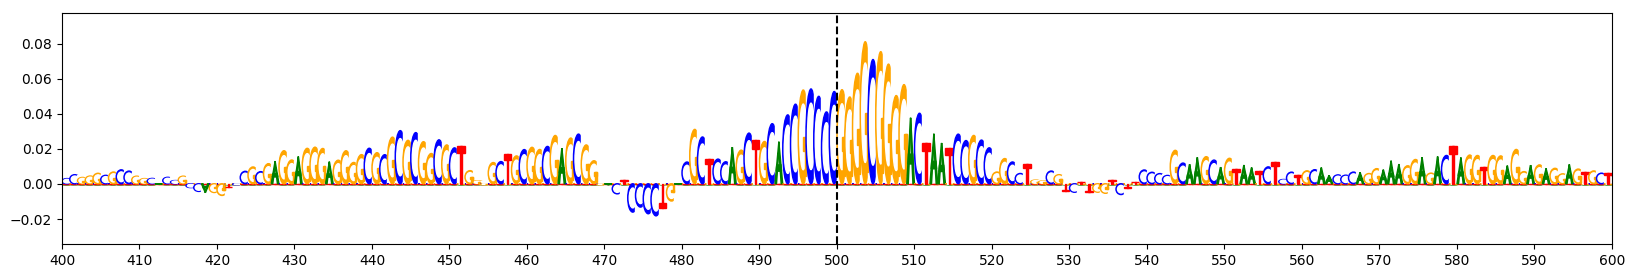

Index:  94  Importance:  2.5706860540200003  RSID:  rs76516995
Minor Allele:  G  Minor Sequence:  GCACCGCCCGCGGGCGGGGA


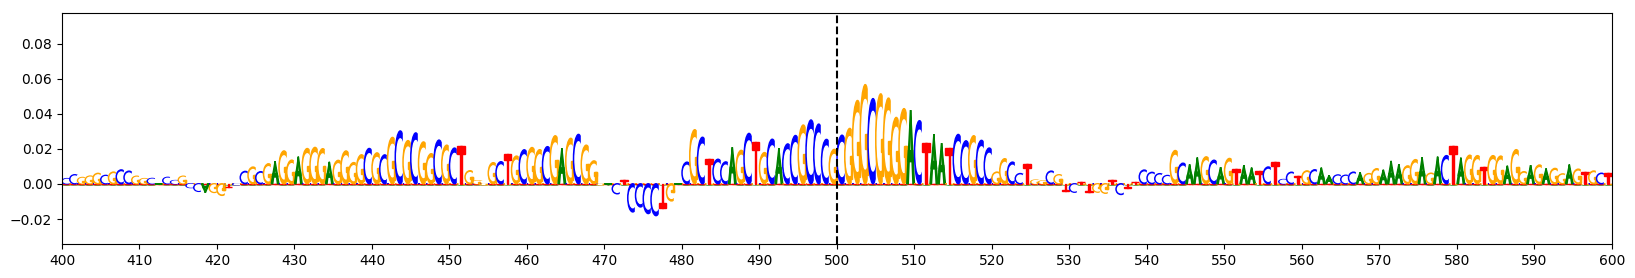

Index:  94  Allele Ratio:  1.277109497582092  RSID:  rs76516995
Major / Minor:  C / G


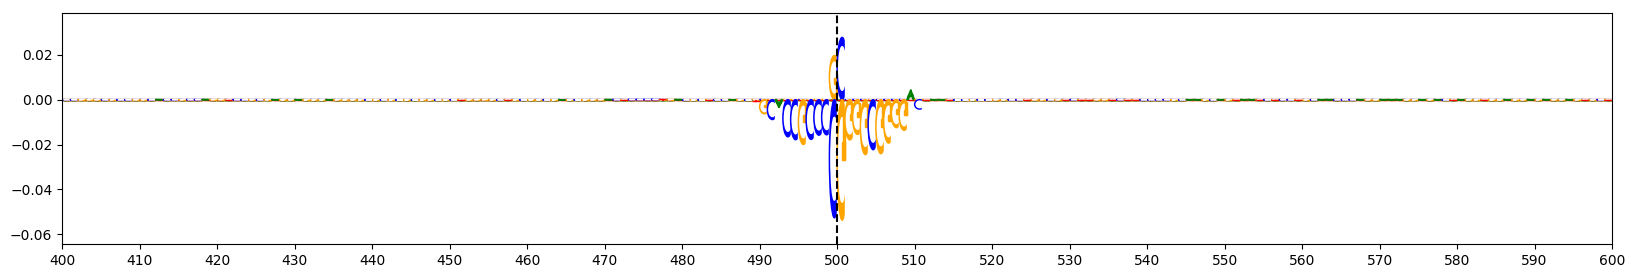

Index:  5  Importance:  2.5252436826640006  RSID:  .   chr11 : 47377525 - 47377526
Major Allele:  A  Major Sequence:  CTCATGCTCACACCCACACA


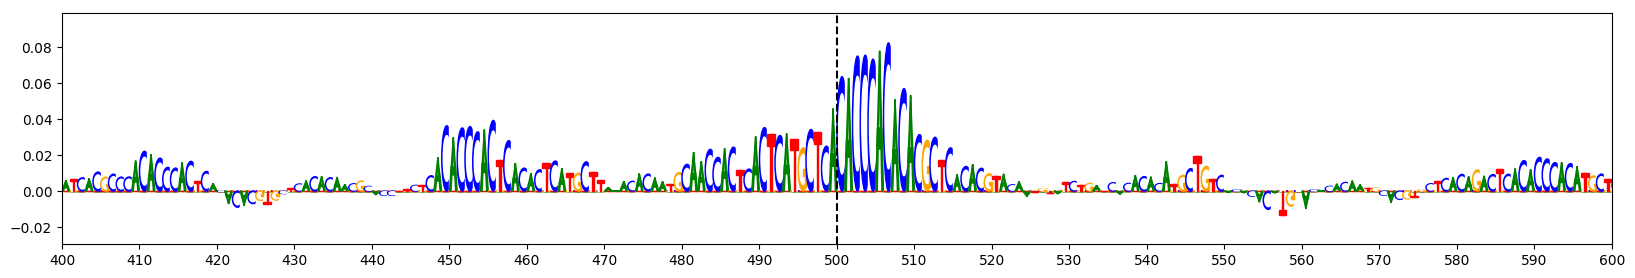

Index:  5  Importance:  2.3891785250149997  RSID:  .
Minor Allele:  G  Minor Sequence:  CTCATGCTCGCACCCACACA


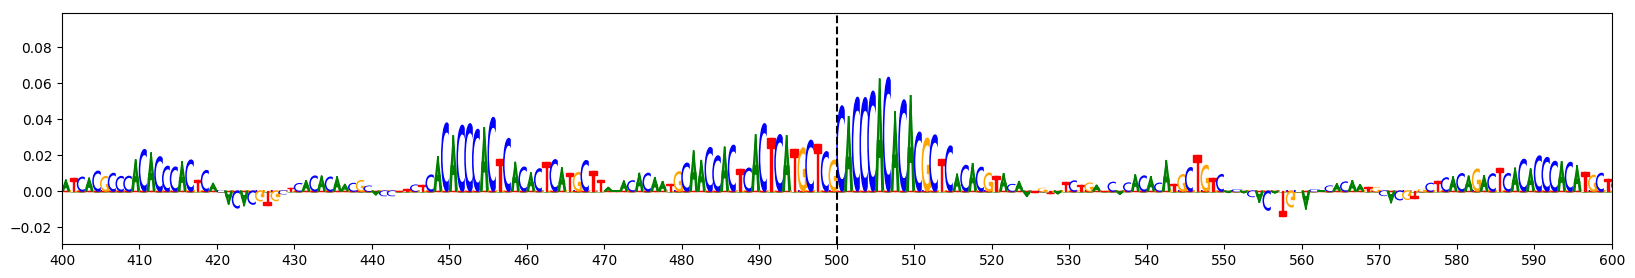

Index:  5  Allele Ratio:  1.1433357260291137  RSID:  .
Major / Minor:  A / G


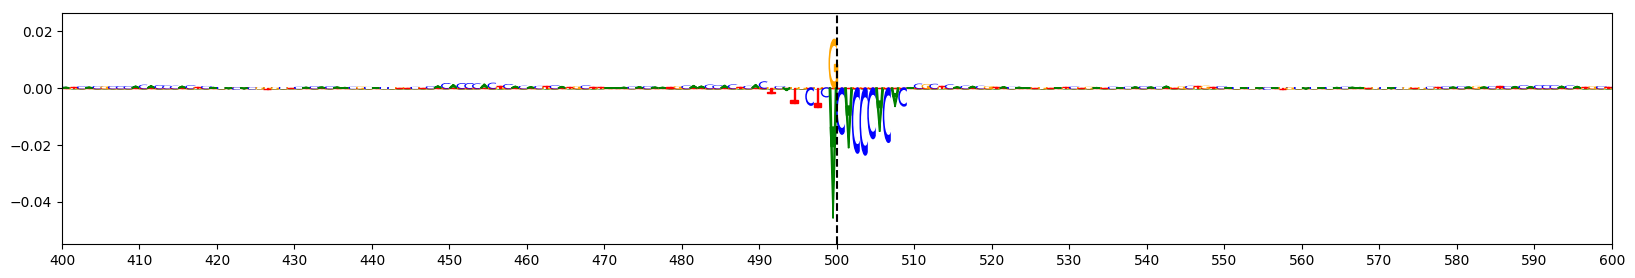

Index:  13  Importance:  0.546209307703  RSID:  rs12292911   chr11 : 47449071 - 47449072
Major Allele:  G  Major Sequence:  TGTGCAATCGTTGCCTTTTT


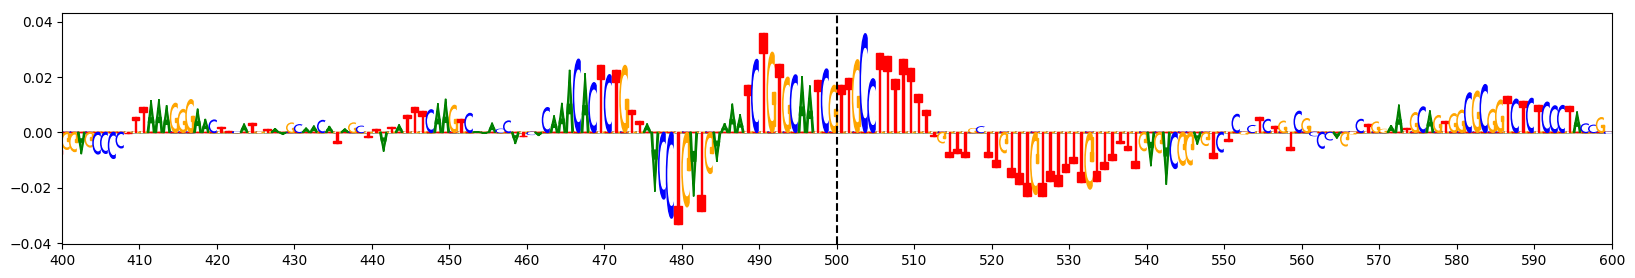

Index:  13  Importance:  0.3850554808819  RSID:  rs12292911
Minor Allele:  A  Minor Sequence:  TGTGCAATCATTGCCTTTTT


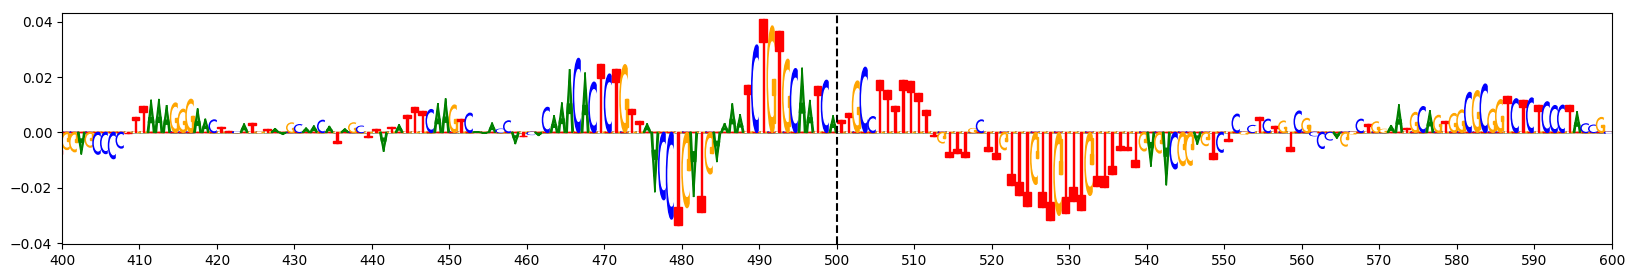

Index:  13  Allele Ratio:  1.1625573637914637  RSID:  rs12292911
Major / Minor:  G / A


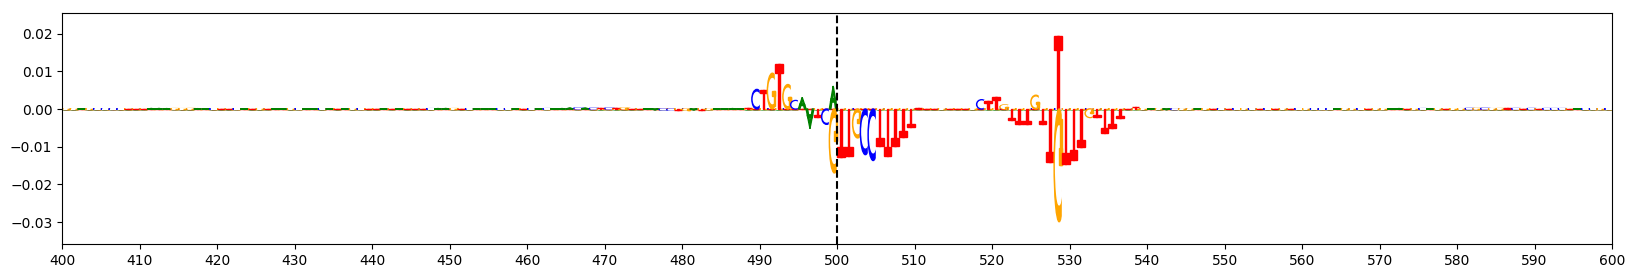

Index:  17  Importance:  2.36498777041  RSID:  .   chr11 : 47522873 - 47522874
Major Allele:  C  Major Sequence:  CCTGTCAGGCAGAAGATGGT


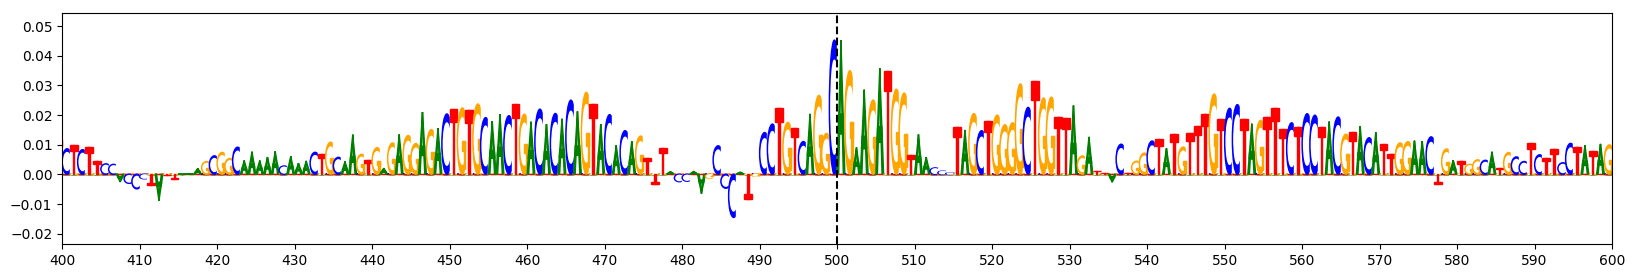

Index:  17  Importance:  1.8473396068399999  RSID:  .
Minor Allele:  T  Minor Sequence:  CCTGTCAGGTAGAAGATGGT


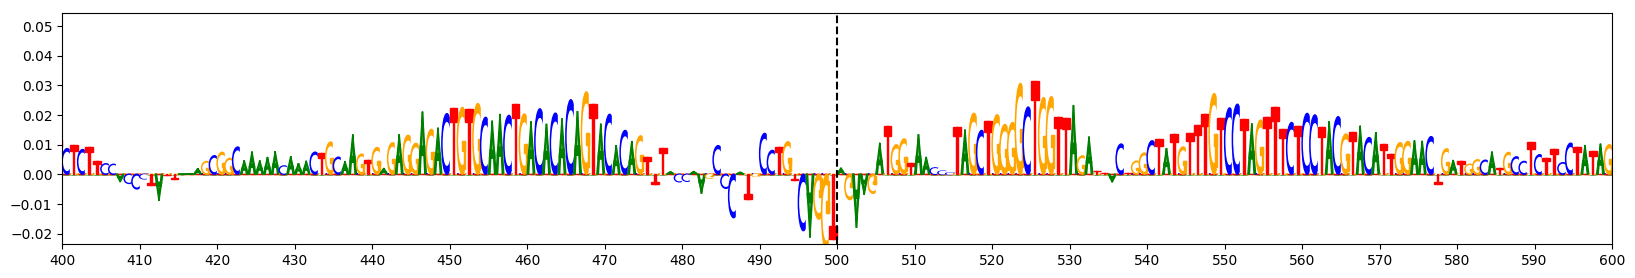

Index:  17  Allele Ratio:  2.1292604978413845  RSID:  .
Major / Minor:  C / T


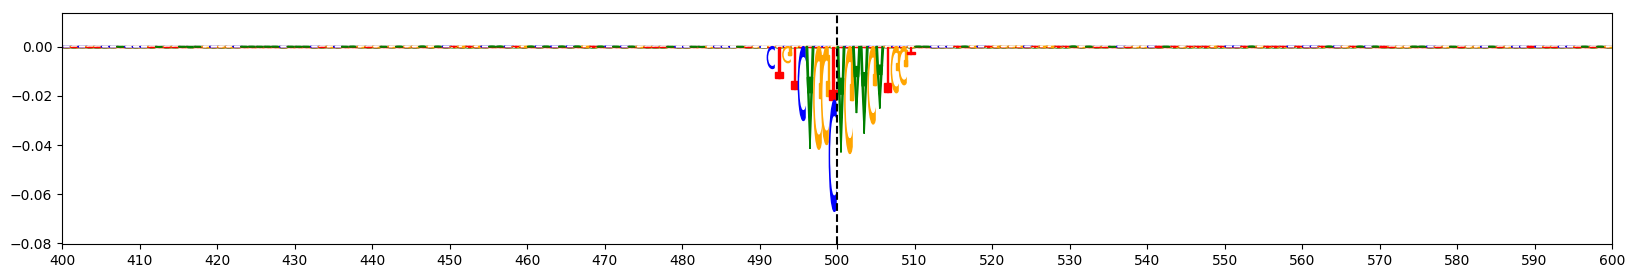

Index:  70  Importance:  1.056134571983  RSID:  rs117316645   chr19 : 45458211 - 45458212
Major Allele:  G  Major Sequence:  GGTTCCTCTGACGAAAGAGG


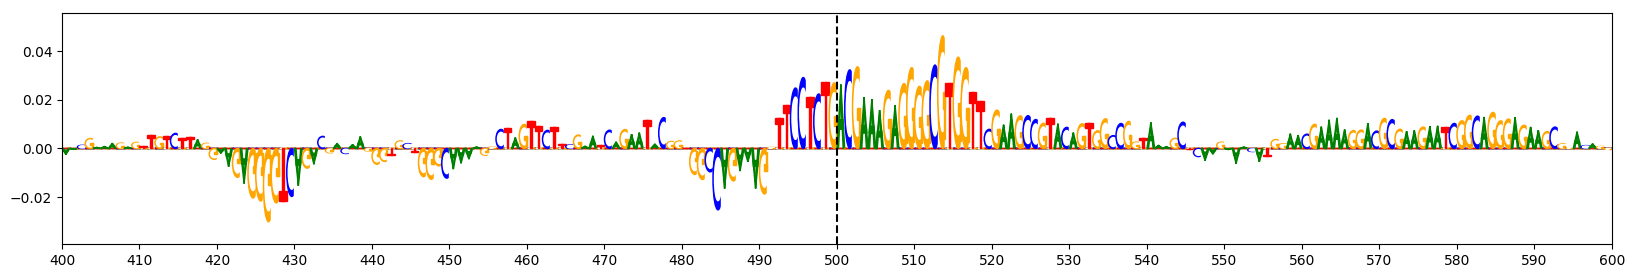

Index:  70  Importance:  0.633671105676  RSID:  rs117316645
Minor Allele:  A  Minor Sequence:  GGTTCCTCTAACGAAAGAGG


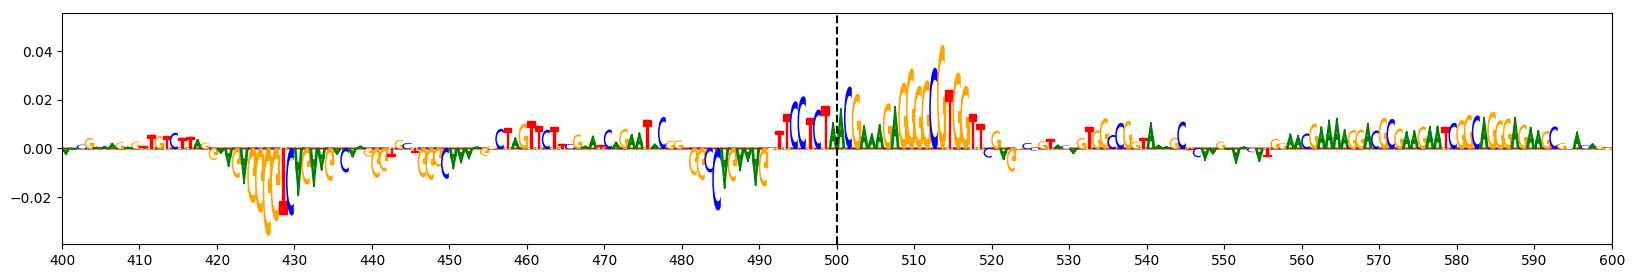

Index:  70  Allele Ratio:  1.4128662998830204  RSID:  rs117316645
Major / Minor:  G / A


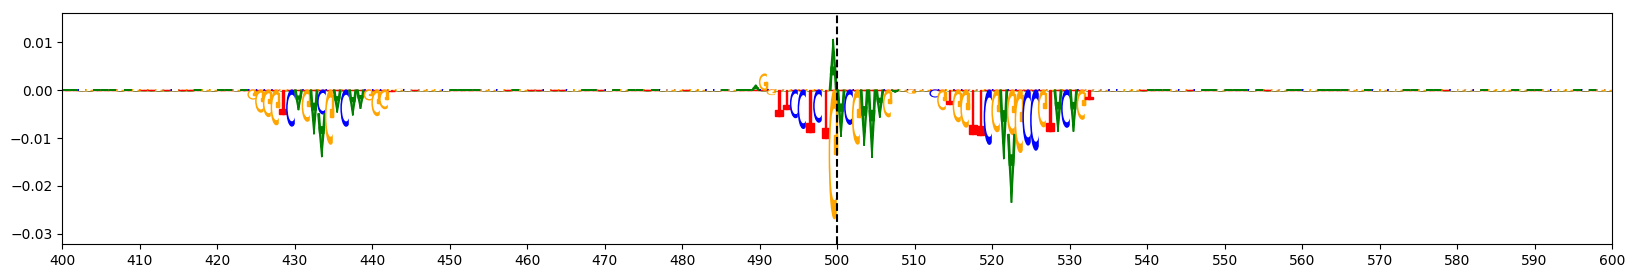

In [47]:
for idx in seq_df_neg.index[:5]:
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx], 
          ' ', seq_df_neg.at[idx, 'chr'], ':', seq_df_neg.at[idx, 'start'], '-', seq_df_neg.at[idx, 'end'])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    ylim = plot_weights(major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_neg.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    a = plot_weights(minor_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Allele Ratio: ", seq_df_neg.at[idx, 'allele_ratio'], " RSID: ", gwas_rsid[idx])
    print("Major / Minor: ", gwas_major[idx] + ' / ' + gwas_minor[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))

## Find Alternate Alleles that Improve Accessibility

In [6]:
seq_df_pos = seq_df.loc[seq_df['allele_ratio'] < 1]
seq_df_pos.sort_values(by=['minor_mult'], ascending=False, inplace=True)
display(seq_df_pos)

,index,chr,start,end,rsid,major,minor,major_score,minor_score,major_center,minor_center,major_ratio,minor_ratio,allele_ratio,major_mult,minor_mult
40,40,chr11,85815029,85815030,rs1237999,A,G,1.144788,2.649763,0.209439,1.538549,0.015436,0.454171,0.136128,0.002101,3.336356
23,23,chr11,60019149,60019150,rs636317,T,C,2.036801,4.732889,1.360193,4.049403,0.430617,0.704728,0.335900,0.144644,2.098030
24,24,chr11,60019160,60019161,rs636341,C,A,1.876078,4.359135,1.258908,3.735955,0.364155,0.466494,0.336971,0.122710,1.384374
81,81,chr19,45504348,45504349,rs35577563,C,G,-0.144863,0.187357,0.239575,0.582205,0.282976,0.512401,0.411496,0.116444,1.245213
124,124,chr8,27226789,27226790,rs755951,A,C,-0.998680,-0.730572,0.396472,0.621830,0.389316,0.543866,0.637589,0.248224,0.853005
101,101,chr6,32551415,32551416,rs9269914,C,G,0.424991,0.628994,0.488078,0.695327,0.320287,0.438619,0.701941,0.224823,0.624866
62,62,chr19,45414450,45414451,rs439401,C,T,2.150407,2.612345,1.371019,1.894606,0.284708,0.419727,0.723643,0.206027,0.580020
77,77,chr19,45470912,45470913,rs10775543,T,G,0.882840,1.301671,0.210393,0.524592,0.039450,0.228629,0.401059,0.015822,0.570063
46,46,chr19,45147718,45147719,rs10426401,T,G,0.625466,1.076969,0.331351,0.718202,0.052363,0.251075,0.461362,0.024158,0.544204
7,7,chr11,47377525,47377526,rs778933900,A,AC,2.525244,2.892618,1.441641,1.760356,0.371830,0.404414,0.818948,0.304509,0.493821


## Visualize Top Sequences

Index:  40  Importance:  2.649763408044  RSID:  rs1237999 chr11 :  85815029  -  85815030
Minor Allele:  G  Minor Sequence:  ATTATCTATGAGTCACCAAC


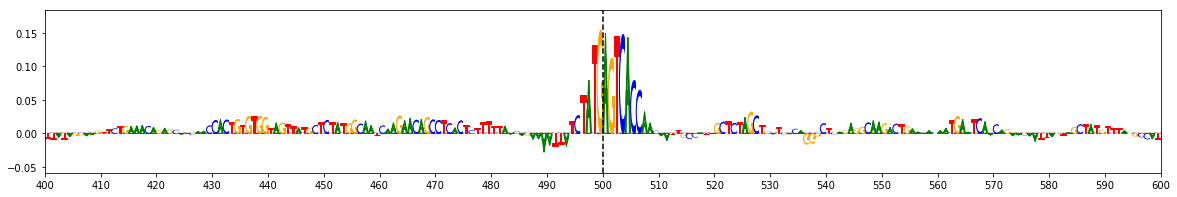

Index:  40  Importance:  1.14478828267  RSID:  rs1237999
Major Allele:  A  Major Sequence:  ATTATCTATAAGTCACCAAC


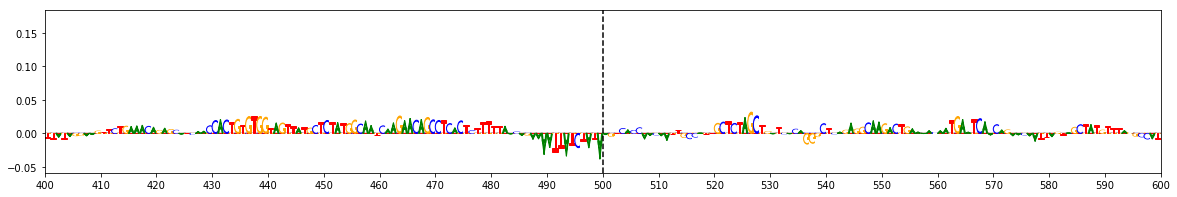

Index:  40  Delta:  0.13612776264367263  RSID:  rs1237999
Minor / Major:  G / A


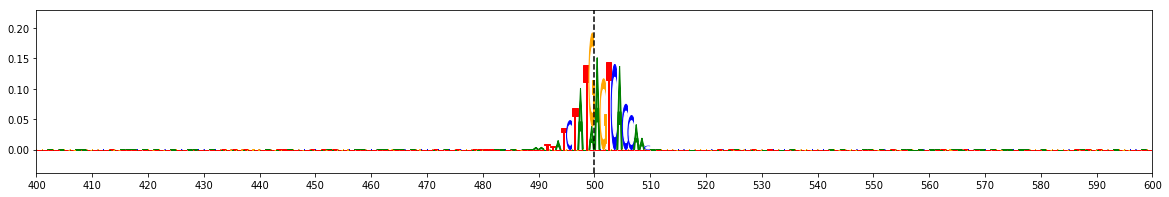

Index:  23  Importance:  4.732889214157001  RSID:  rs636317 chr11 :  60019149  -  60019150
Minor Allele:  C  Minor Sequence:  CTTTGCTGCCATCTGCTGGG


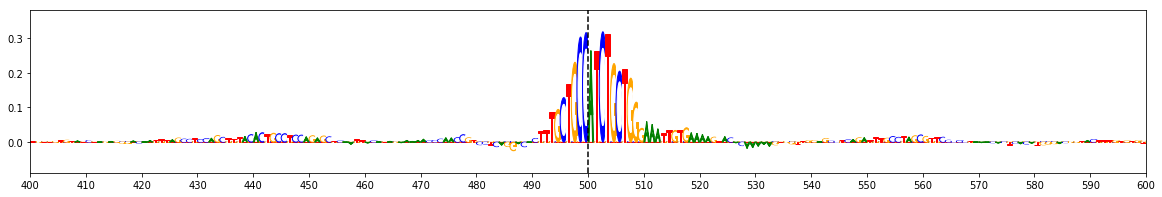

Index:  23  Importance:  2.036801192096  RSID:  rs636317
Major Allele:  T  Major Sequence:  CTTTGCTGCTATCTGCTGGG


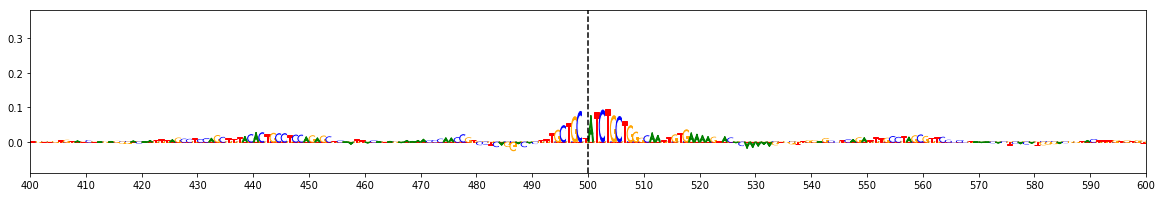

Index:  23  Delta:  0.3358997400433063  RSID:  rs636317
Minor / Major:  C / T


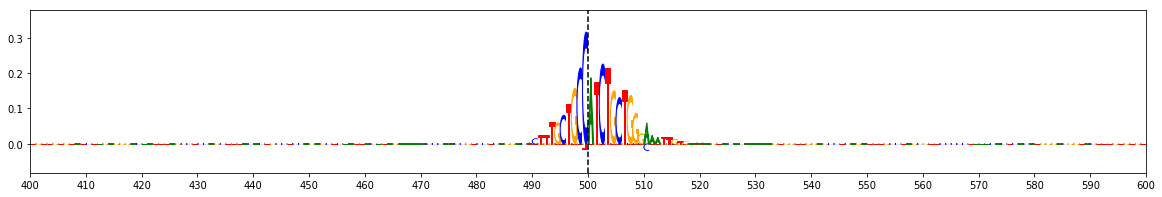

Index:  24  Importance:  4.359134659074  RSID:  rs636341 chr11 :  60019160  -  60019161
Minor Allele:  A  Minor Sequence:  TCTGCTGGGAAATTGTGAAA


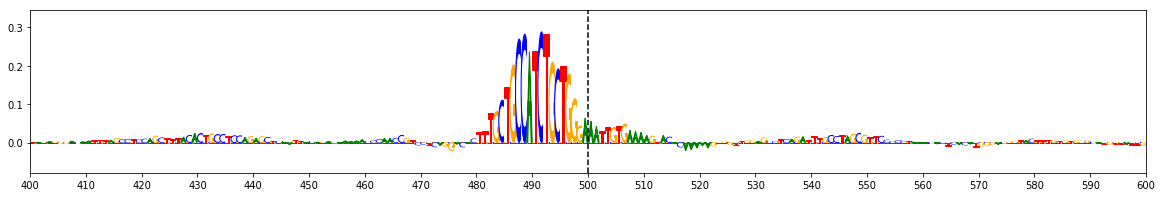

Index:  24  Importance:  1.876077817875  RSID:  rs636341
Major Allele:  C  Major Sequence:  TCTGCTGGGCAATTGTGAAA


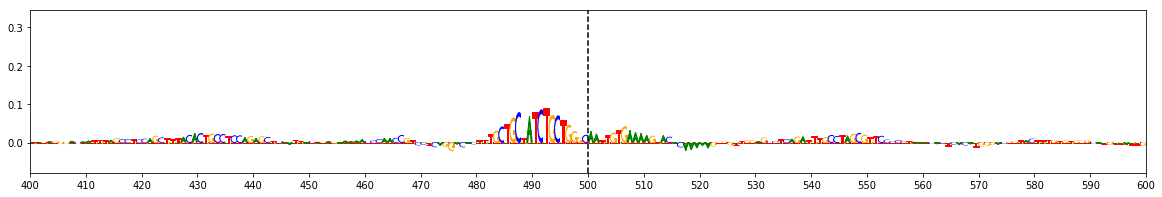

Index:  24  Delta:  0.3369708454921387  RSID:  rs636341
Minor / Major:  A / C


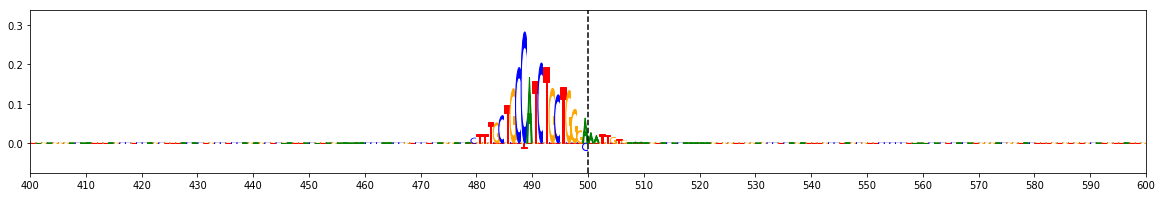

Index:  81  Importance:  0.18735698978799997  RSID:  rs35577563 chr19 :  45504348  -  45504349
Minor Allele:  G  Minor Sequence:  AGAGCCCTGGCAACCTCTCG


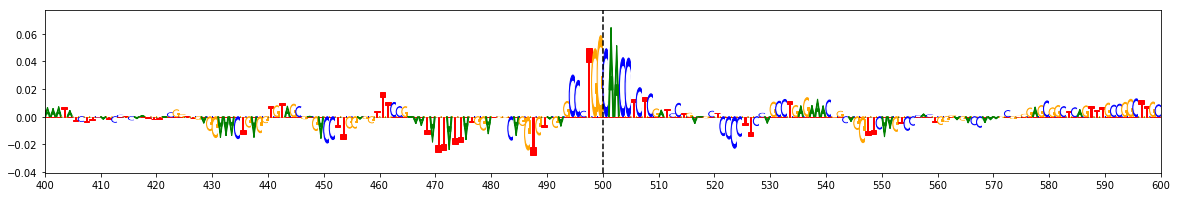

Index:  81  Importance:  -0.14486324750800006  RSID:  rs35577563
Major Allele:  C  Major Sequence:  AGAGCCCTGCCAACCTCTCG


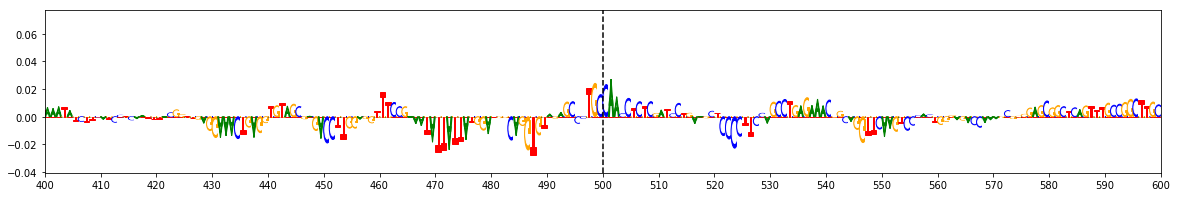

Index:  81  Delta:  0.4114962433494823  RSID:  rs35577563
Minor / Major:  G / C


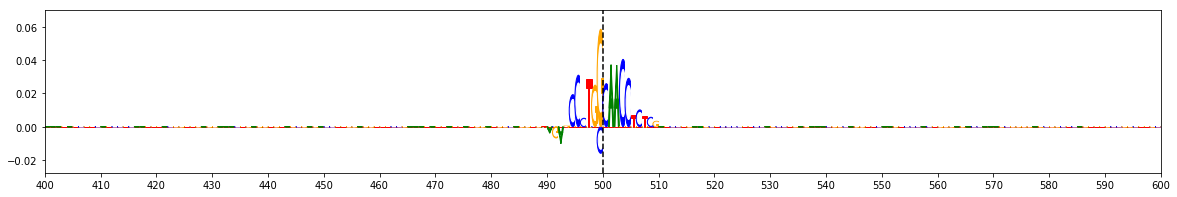

Index:  124  Importance:  -0.7305715545011  RSID:  rs755951 chr8 :  27226789  -  27226790
Minor Allele:  C  Minor Sequence:  TTCACTGGCCTGTAGGGGGA


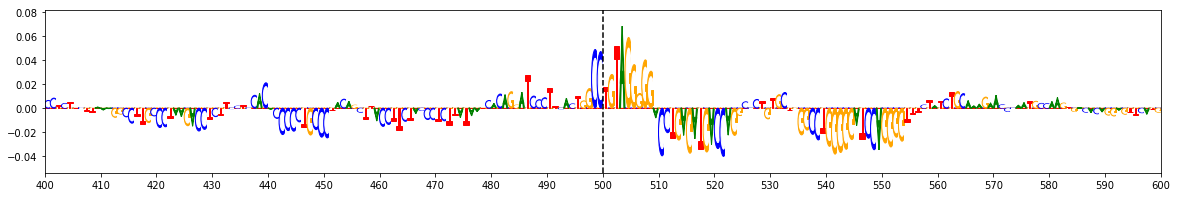

Index:  124  Importance:  -0.9986803372906001  RSID:  rs755951
Major Allele:  A  Major Sequence:  TTCACTGGCATGTAGGGGGA


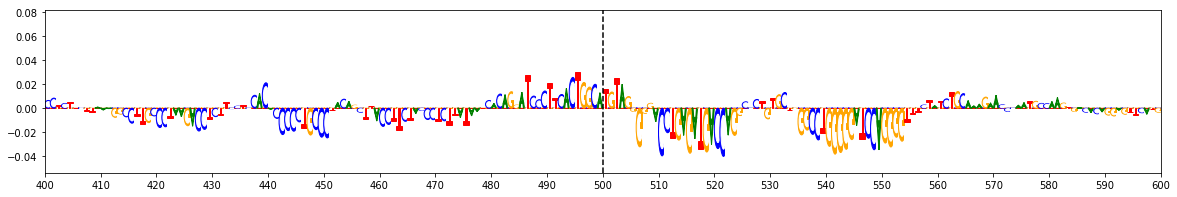

Index:  124  Delta:  0.6375886591768618  RSID:  rs755951
Minor / Major:  C / A


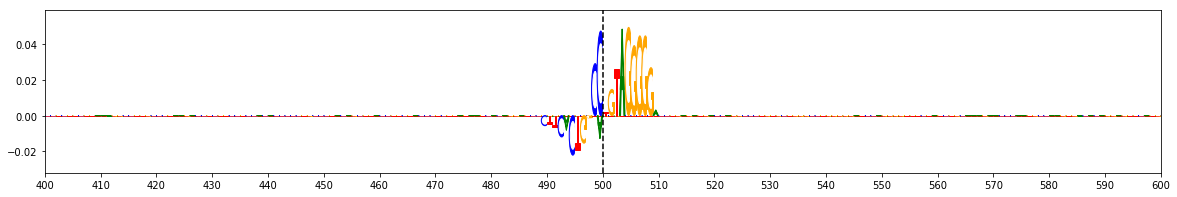

In [7]:
for idx in seq_df_pos.index[:5]:
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'minor_score'], " RSID: ", gwas_rsid[idx], 
          seq_df_pos.at[idx, 'chr'], ': ', seq_df_pos.at[idx, 'start'], ' - ', seq_df_pos.at[idx, 'end'])
    print("Minor Allele: ", gwas_minor[idx], ' Minor Sequence: ', minor_seqs[idx][490:510])
    ylim = plot_weights(minor_imp_scores[idx], subticks_frequency=10, xlim=(400,600))
    print("Index: ", idx, " Importance: ", seq_df_pos.at[idx, 'major_score'], " RSID: ", gwas_rsid[idx])
    print("Major Allele: ", gwas_major[idx], ' Major Sequence: ', major_seqs[idx][490:510])
    a = plot_weights(major_imp_scores[idx], subticks_frequency=10, ylim=ylim, xlim=(400,600))
    print("Index: ", idx, " Delta: ", seq_df_pos.at[idx, 'allele_ratio'], " RSID: ", gwas_rsid[idx])
    print("Minor / Major: ", gwas_minor[idx] + ' / ' + gwas_major[idx])
    a = plot_weights(minor_imp_scores[idx] - major_imp_scores[idx], subticks_frequency=10, xlim=(400,600))